#### Crystal Violet Plaques

#### Loading packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import re
from skimage.exposure import adjust_gamma
from tqdm.auto import tqdm

from PyPlaque.experiment import ExperimentCrystalVioletPlaque
from PyPlaque.specimen import PlaquesImageGray, PlaquesMask
from PyPlaque.view import PlateImage
from PyPlaque.utils import (stitch_wells, centroid, compare_plaque_detection_from_image,
                                                plot_bbox_plaques_mask, boxplot_quants)

/Users/de29/Applications/miniforge3/envs/pyplaque/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Initialising parameters and data
###### Since we would now like to get the readouts and see the usefulness other functionalities from PyPlaque for a Crystal Violet Plate, we define a new ```ExperimentCrystalVioletPlaque``` class instance to work with them.<br> ```base_dir``` is folder above the image and mask folders for all the plates. ```params``` are set to None to choose using the default parameters but values can be updated. <br>Using ```exp.get_individual_plates()``` we get the individual plate and plate mask folders for the given pattern and ```exp.get_number_of_plates()``` gives us the number of plates found according to the ```folder_pattern``` regex (https://docs.python.org/3/howto/regex.html), here just 1. The maximum number of wells per channel here for the data we have considered is 6.

In [2]:
# Loading multiple plates and plate masks as an experiment
base_dir = '../../../data_backup/samples_crystal_violet_plaques/'

exp = ExperimentCrystalVioletPlaque(base_dir+'plaques_image_png/', base_dir+'plaques_mask_png/',
                                        params = None) # default values in class, option to update

In [3]:
# In this case, the individual plate is of 6 wells for crystal violet plaques and
# their corresponding mask directories. Make sure to have similar directories for 
# images and masks(even if empty)
plate_dirs, plate_mask_dirs = exp.get_individual_plates(folder_pattern=r'6446$')

print(plate_dirs, plate_mask_dirs)

# We are choosing via the pattern above to ignore all other plates other than this one
print(exp.get_number_of_plates())

['IMG_6446'] ['IMG_6446']
1


#### Crystal Violet Wells and Masks
###### ```exp.load_well_images_and_masks_for_plate()``` helps us load into memory all data for the crystal violet plate, corresponding to the given index from the plates found ```plate_id``` and file pattern ```file_pattern```. Here the mask path is not empty for us but they can also be generated from images as we will show later. Unlike in Fluorescent Plate we do not generate these by default if missing since it is a little more difficult in this case and it is up to the user whether to use it after seeing the results below.<br>We also show an example where we can take only one well into consideration by using the appropriate ```file_pattern``` regex here ```'png_1'``` within ```exp.load_well_images_and_masks_for_plate()```. Next we show reading of more wells according to other file patterns.

In [4]:
#Example considering 1 particular well 'png_1' from the selected plate
plate_dict = exp.load_well_images_and_masks_for_plate(plate_id=0, additional_subfolders=None,
                                                                            file_pattern=r'png_1')
print(plate_dict.keys())

6it [00:00, 7813.05it/s]
100%|██████████| 1/1 [00:00<00:00, 214.50it/s]
6it [00:00, 24082.13it/s]
100%|██████████| 1/1 [00:00<00:00, 2661.36it/s]

dict_keys(['IMG_6446'])


###### We then show the image name, image and mask from the loaded data for the single well ```'png_1'```.

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_1.png


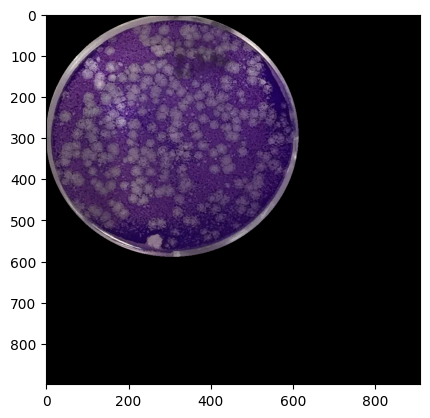

In [5]:
print(plate_dict[plate_dirs[0]]['image_name'][0])
plt.imshow(plate_dict[plate_dirs[0]]['img'][0])

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_1.png


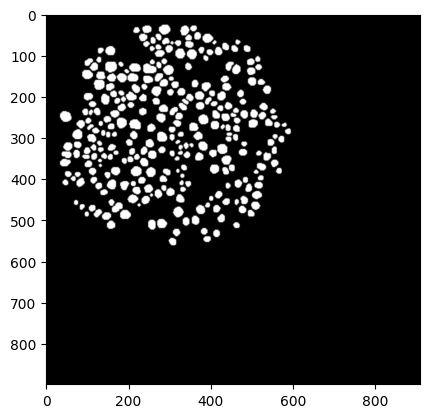

In [6]:
print(plate_dict[plate_dirs[0]]['image_name'][0])
plt.imshow(plate_dict[plate_dirs[0]]['mask'][0], cmap='gray')

In [7]:
#Example considering all wells from the selected plate
plate_dict = exp.load_well_images_and_masks_for_plate(plate_id=0, additional_subfolders=None,
                                                                                file_pattern=None)
print(plate_dict.keys())

6it [00:00, 12665.24it/s]
100%|██████████| 6/6 [00:00<00:00, 3610.07it/s]
6it [00:00, 20344.24it/s]
100%|██████████| 6/6 [00:00<00:00, 4243.10it/s]

dict_keys(['IMG_6446'])


###### We then check the correctness of the number of images found based on our path and identification patterns. Here is should be 6 since we chose to read all the wells of the plate.

In [8]:
print(len(plate_dict[plate_dirs[0]]['img']))

6


#### Grayscale Crystal Violet Wells and Masks
###### ```exp.load_well_images_and_masks_for_plate()``` also has the option to load into memory all data for the crystal violet plate in grayscale using the ```all_grayscale``` flag. This is particularly useful because it reduces our computation cost due to single channel instead of multi-channel images and is necessary for certain functionalities such as eccentricity readouts of plaques in a well.<br> We then verify the number of images read and show an image name, image from the loaded data for the plate.

In [9]:
# Example considering all wells from the selected plate reading images also in grayscale
plate_dict = exp.load_well_images_and_masks_for_plate(plate_id=0, additional_subfolders=None,
                                                            all_grayscale=True, file_pattern=None)
print(plate_dict.keys())

6it [00:00, 18752.48it/s]
100%|██████████| 6/6 [00:00<00:00, 62.03it/s]
6it [00:00, 23990.30it/s]
100%|██████████| 6/6 [00:00<00:00, 444.45it/s]

dict_keys(['IMG_6446'])


../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_1.png


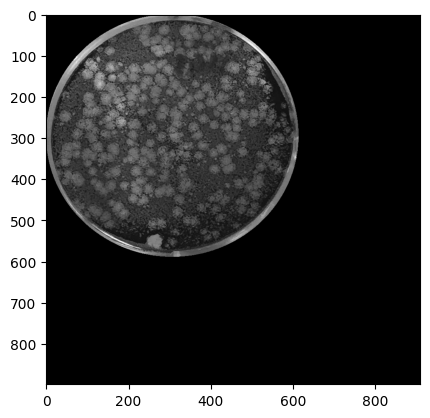

In [10]:
print(plate_dict[plate_dirs[0]]['image_name'][0])
plt.imshow(plate_dict[plate_dirs[0]]['img'][0], cmap='gray')

###### We can use the function ```exp.extract_masked_wells()``` to get the masked image of the wells that helps us to get an unobstructed view of the plaques in the wells without the background of the plate, medium or any other noise.<br> Here we take the image from index 0 of the plate dictionary ```plate_dict``` and show the masked plaques in it.

In [11]:
# Assuming that wells were numbered in raster scan fashion from left to right, row by row
plate_dict = exp.extract_masked_wells(plate_id=0)

100%|██████████| 6/6 [00:00<00:00, 1202.84it/s]


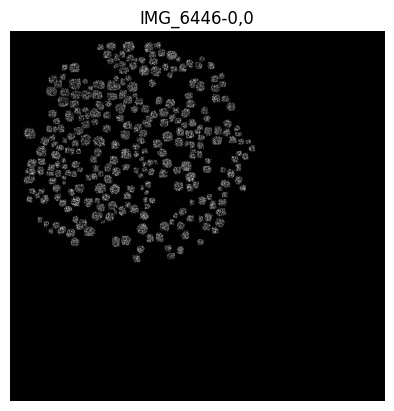

In [12]:
i = 0
j = 0
plt.figure()
plt.axis('off')
plt.title(plate_dirs[0]+"-"+str(i)+","+str(j))
plt.imshow(plate_dict[plate_dirs[0]]['masked_img'][0], cmap='gray')
# plt.savefig("../../../manuscript/figs/masked_plaques_6446_"+str(i)+str(j)+".png",
# bbox_inches='tight', dpi=300)

#### Well Stitching
###### It is possible that sometimes we want to work with more than 1 the 6 wells of a plate but instead have only individual images and masks. In that case we can stitch certain wells together to generate an artificial view of the whole plate. Please note that the images passed to be stitched should be in an array in raster scan fashion from left to right, row by row and all rows and columns must be complete (i.e. number images passed should match the number of rows and columns passed). Also that the resulting ```composite_img``` should have shape ```(nrows*indiv_shape[0], ncolumns*indiv_shape[1])``` where ```indiv_shape``` is the shape of an individual well image.<br>We also show further on how we can also combine the wells of the well plate using the indices of the images or regex to identify the wells to stitch.

In [13]:
# Stitching of multiple selected wells into a composite image 
composite_img = stitch_wells([plate_dict[plate_dirs[0]]['img'][i] for i in (0, 1, 2)],
                                                            nrows = 1, ncols = 3) 
#nrows = 2, ncols = 3

# OR
# change regex to choose wells to stitch
img_list = [img for i, img in enumerate(plate_dict[plate_dirs[0]]['img'])
            if len(re.findall(r'.(png)_([1-3]{1})',
            str(plate_dict[plate_dirs[0]]['image_name'][i]))) > 0] 

composite_img_corner = stitch_wells(img_list, nrows=1, ncols=3)

print(plate_dict[plate_dirs[0]]['img'][0].shape)
print(composite_img.shape) 


(899, 910)
(899, 2730)


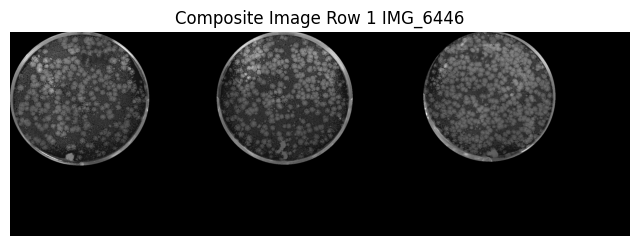

In [14]:
plt.figure(figsize=(8,12))
plt.title("Composite Image Row 1 " + plate_dirs[0])
plt.axis('off')

plt.imshow(composite_img, cmap='gray')

# The image is more clearly visible only after converting to 8/16bit and some 
# thresholding
# plt.savefig("../../../manuscript/figs/" + plate_dirs[0] + " Stitched images.png", 
# bbox_inches = 'tight', dpi=300)

#### Getting Plaque Count
###### Since counting of plaques in a viral well is one of the most basic tasks performed by virologists, we would want to use automated software such as PyPlaque to achieve it. We can do so by instantiating the ```PlaquesMask()``` class for each of the wells (here only the mask of the well being important for the count). We can then use the ```plq_mask.get_plaques()``` function to get the count of the plaque in the well. The ```min_area``` and ```max_area``` parameters here can help to look at a different set of plaques within the size range of the default value of these parameters can be used.

In [15]:
#Getting count of plaques from the binary masks of the plaques
plaques_mask_gt_list = [PlaquesMask(name = str(plate_dict[plate_dirs[0]]['image_name'][i]),
                                plaques_mask = plate_dict[plate_dirs[0]]['mask'][i]) 
                    for i in tqdm(range(len(plate_dict[plate_dirs[0]]['img'])))]
plaques_count_gt_list = [len(plq_mask.get_plaques()) for plq_mask in tqdm(plaques_mask_gt_list)]

[print(plq_mask.name, " : ", plq_count, "\n") for (plq_mask, plq_count) 
in tqdm(list(zip(plaques_mask_gt_list, plaques_count_gt_list)))]


100%|██████████| 6/6 [00:00<00:00, 95325.09it/s]

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_1.png  :  114 

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_2.png  :  109 

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_3.png  :  166 

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_4.png  :  82 

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_5.png  :  6 

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_6.png  :  0 



[None, None, None, None, None, None]

#### Mask Generation Plaques
###### Here we create a new instance of an experiment ```exp2``` where we assume that we do not have the mask of the plaques available. We can tell the experiment to not expect it using the ```read_mask``` flag by setting it to False.Here we take only one well into consideration by using the appropriate ```file_pattern``` regex here ```'png_1'```.We show the resulting binary virus mask that is formed based on ```params``` that are the default ones used here.

6it [00:00, 17403.75it/s]
100%|██████████| 1/1 [00:00<00:00, 138.91it/s]

../../../data_backup/samples_crystal_violet_plaques/plaques_image_png/IMG_6446/IMG_6446.png_1.png


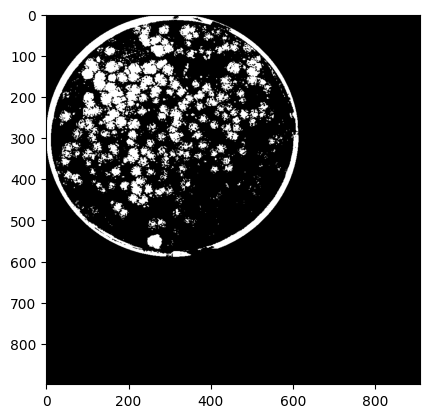

In [16]:
# Getting masks generated from images in case we do not have them already
exp2 = ExperimentCrystalVioletPlaque(base_dir+'plaques_image_png/', base_dir+'plaques_mask_png/',
                                        params = None) # default values in class, option to update
_, _ = exp2.get_individual_plates(folder_pattern=r'6446$')
plate_dict_no_mask = exp2.load_well_images_and_masks_for_plate(plate_id=0,
                additional_subfolders=None, read_mask=False, all_grayscale=True, 
                file_pattern=r'png_1')
print(plate_dict_no_mask[plate_dirs[0]]['image_name'][0])
plt.imshow(plate_dict_no_mask[plate_dirs[0]]['mask'][0], cmap='gray')

#### Gamma adjustment of images before Mask Generation
###### Here we try to show a comparison of mask generation and therefore plaque detection results by using the raw images in grayscale and a gamma adjusted version of the images using ```adjust_gamma```. Parameters for gamma adjustment are set by default in the experiment but can be changed. We use the ```PlaquesImageGray()``` class to store the grayscale images (gamma adjsuted or otherwise) and then generate the plaque masks using parameters ```threshold``` and ```sigma```. ```plaques_mask_gadjusted_list``` contains the plaques detected from gamma adjusted grayscale images while ```plaques_list``` contains the plaques detected from the raw grayscale images.

In [17]:
#Verifying the count of plaques by generating masks from the images of the plaques themselves, 
# gamma adjusting for better detection
img_gadjusted_list = [adjust_gamma(img, 
                                gamma=exp.params['crystal_violet']['gamma'],
                                gain=exp.params['crystal_violet']['gain']) 
                        for img in tqdm(plate_dict[plate_dirs[0]]['img'])]

plaques_mask_list = [PlaquesImageGray(plate_dirs[0]+"-"+
                                        str(i//exp.params['crystal_violet']['ncols'])+","+
                                        str(i%exp.params['crystal_violet']['ncols']),
                                plate_dict[plate_dirs[0]]['img'][i],
                                threshold=exp.params['crystal_violet']['threshold'],
                                sigma=exp.params['crystal_violet']['sigma']) 
                        for i in tqdm(range(len(plate_dict[plate_dirs[0]]['img'])))]

plaques_list = [plq_mask.get_plaques(min_area = exp.params['crystal_violet']['min_area'], 
                                max_area = exp.params['crystal_violet']['max_area']) 
                    for plq_mask in tqdm(plaques_mask_list)]

plaques_mask_gadjusted_list = [PlaquesImageGray(plate_dirs[0]+"-"+
                                        str(i//exp.params['crystal_violet']['ncols'])+","+
                                        str(i%exp.params['crystal_violet']['ncols']),
                                        img_gadjusted_list[i],
                                        threshold=exp.params['crystal_violet']['threshold'],
                                        sigma=exp.params['crystal_violet']['sigma']) 
                                for i in tqdm(range(len(plate_dict[plate_dirs[0]]['img'])))]

plaques_gadjusted_list = [plq_mask_gadjusted.get_plaques(
                                                min_area = exp.params['crystal_violet']['min_area'], 
                                                max_area = exp.params['crystal_violet']['max_area']) 
                            for plq_mask_gadjusted in tqdm(plaques_mask_gadjusted_list)]


100%|██████████| 6/6 [00:00<00:00, 17.05it/s]


###### Here we try to visualise the comparison of mask generation and therefore plaque detection results by using the raw images in grayscale and a gamma adjusted version of the images using ```compare_plaque_detection_from_image```. Important to note is the counts such as ```IMG_6446-0,0  true count``` which is the count obtained for that well from the manually generated best quality plaque masks and therefore our target. Then we have the ones such as ```IMG_6446-0,0  :  5``` which is the count of plaques detected from the raw grayscale images and finally the likes of ```IMG_6446-0,0  gamma adjusted :  29``` which is the count of plaques detected from the gamma adjusted grayscale images. The plots are alse named similarly as the counts to visualise the location of the plaques detected in each case.

  0%|          | 0/6 [00:00<?, ?it/s]

IMG_6446-0,0  true count :  114
IMG_6446-0,0  :  5
IMG_6446-0,0  gamma adjusted :  29


100%|██████████| 29/29 [00:00<00:00, 35638.68it/s]


100%|██████████| 29/29 [00:00<00:00, 3651.38it/s]


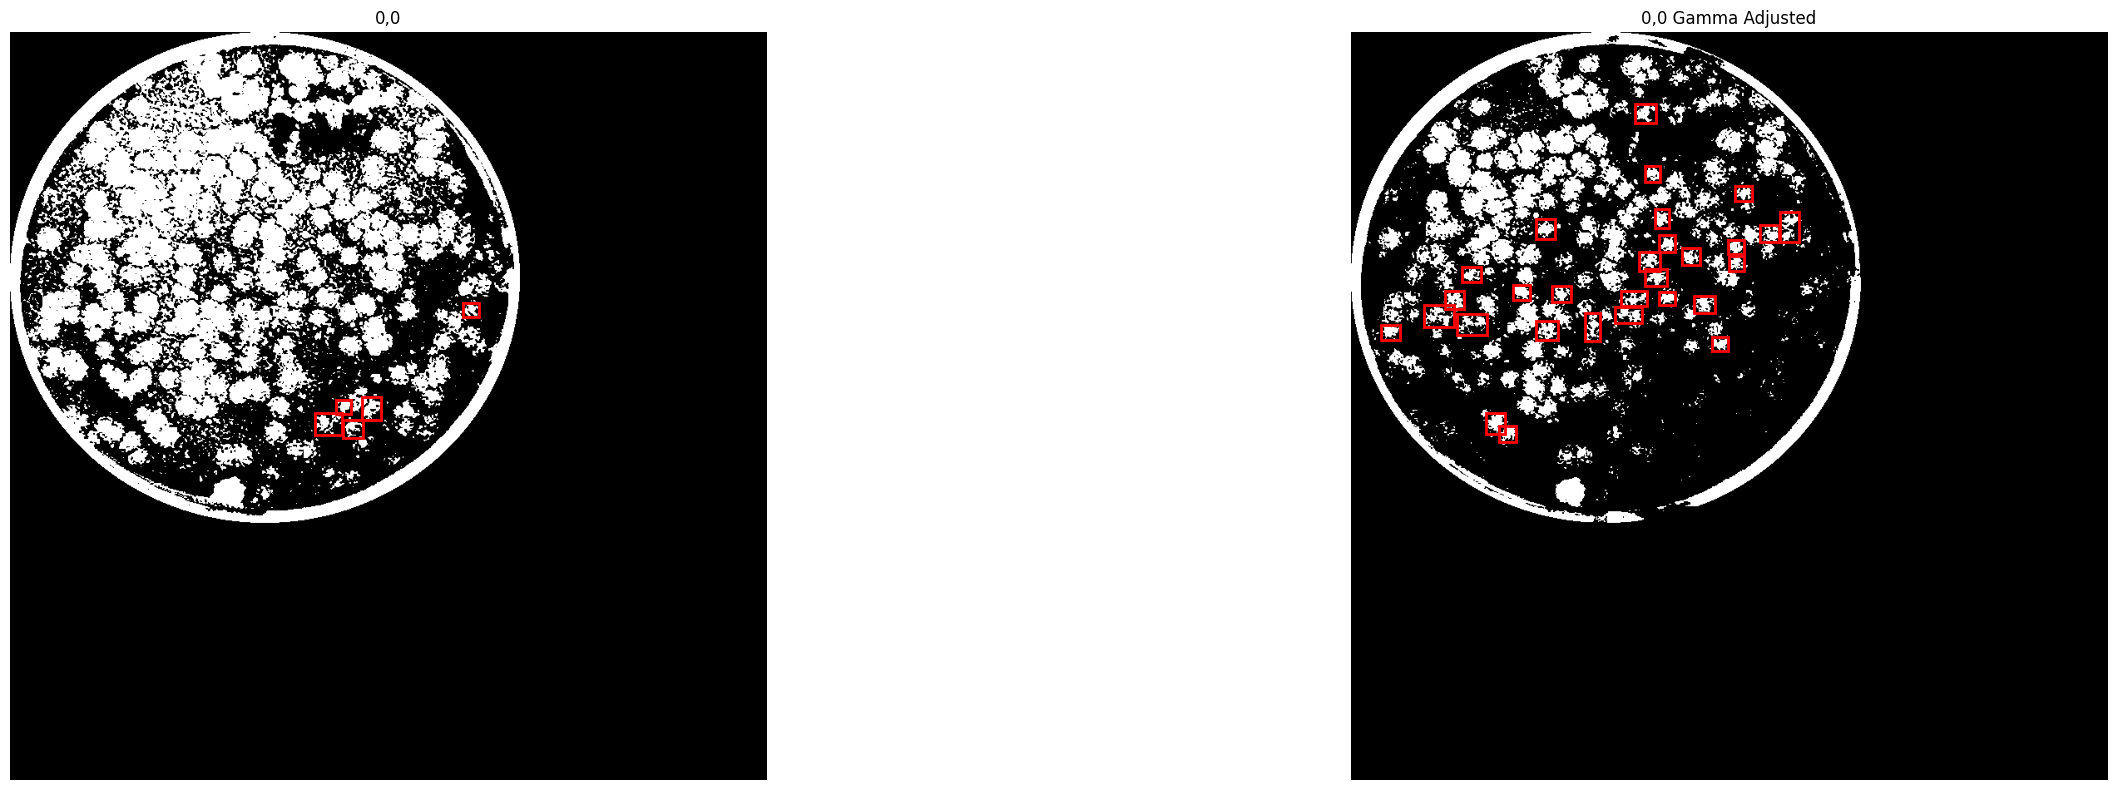

 17%|█▋        | 1/6 [00:00<00:01,  3.28it/s]

IMG_6446-0,1  true count :  109
IMG_6446-0,1  :  15
IMG_6446-0,1  gamma adjusted :  16


100%|██████████| 16/16 [00:00<00:00, 4367.64it/s]


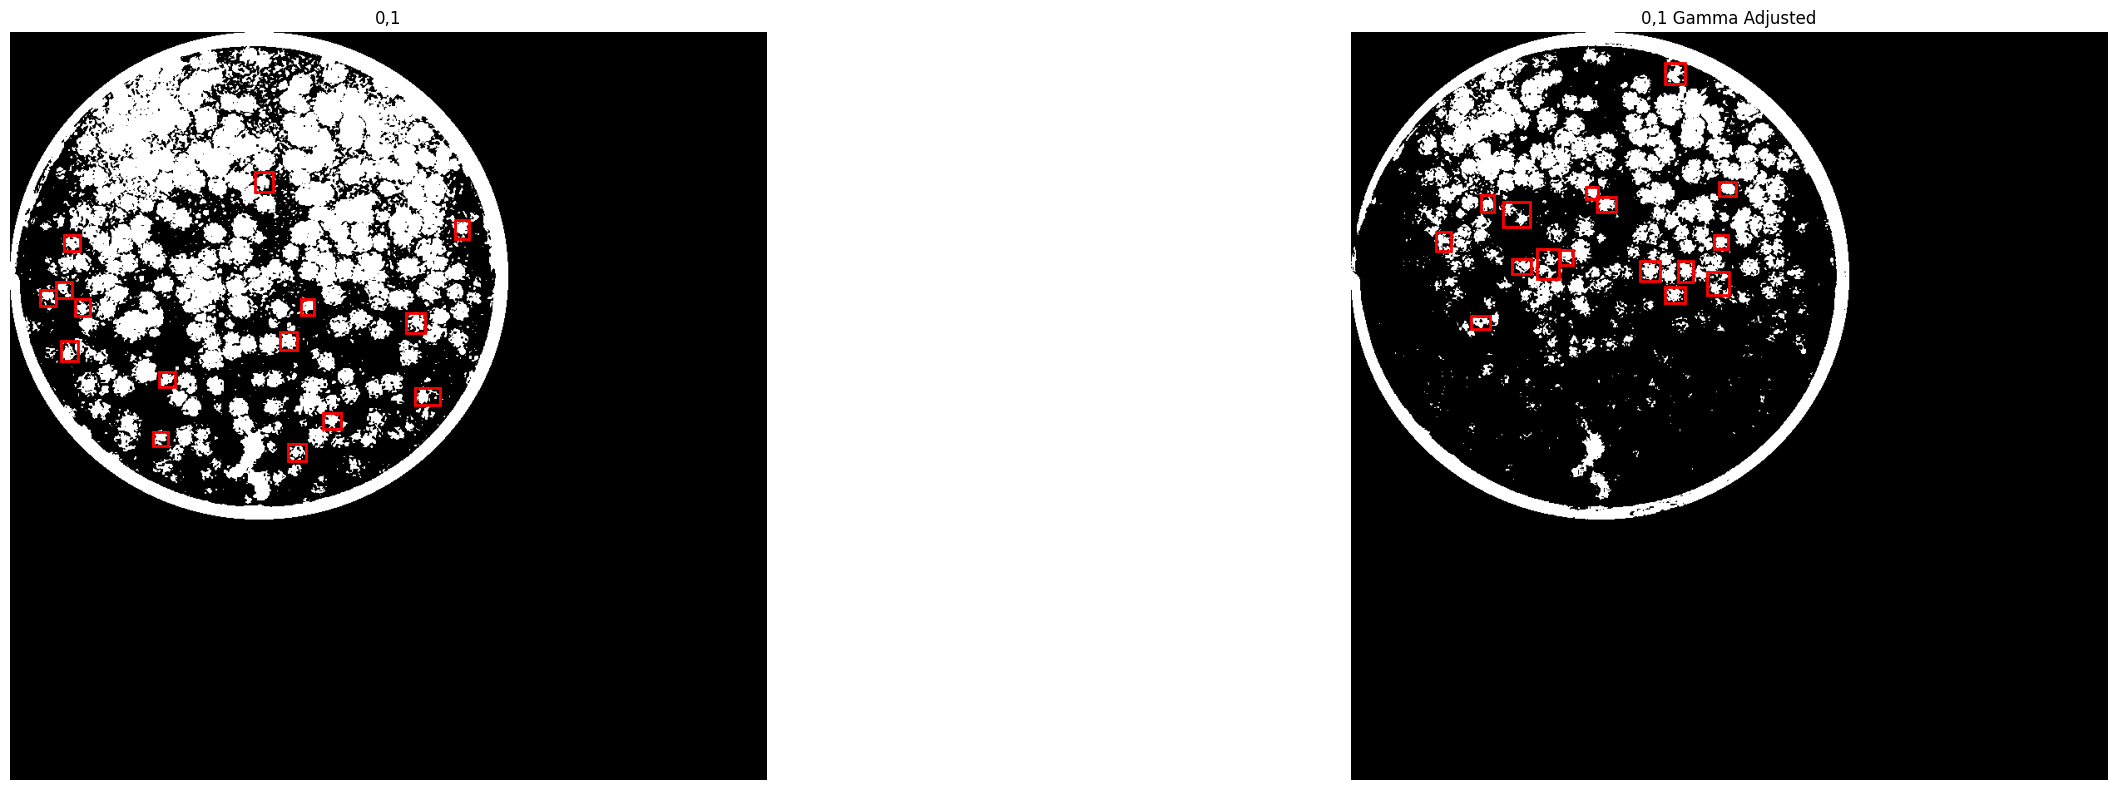

 33%|███▎      | 2/6 [00:00<00:01,  3.30it/s]

IMG_6446-0,2  true count :  166
IMG_6446-0,2  :  3
IMG_6446-0,2  gamma adjusted :  22


100%|██████████| 22/22 [00:00<00:00, 3968.29it/s]


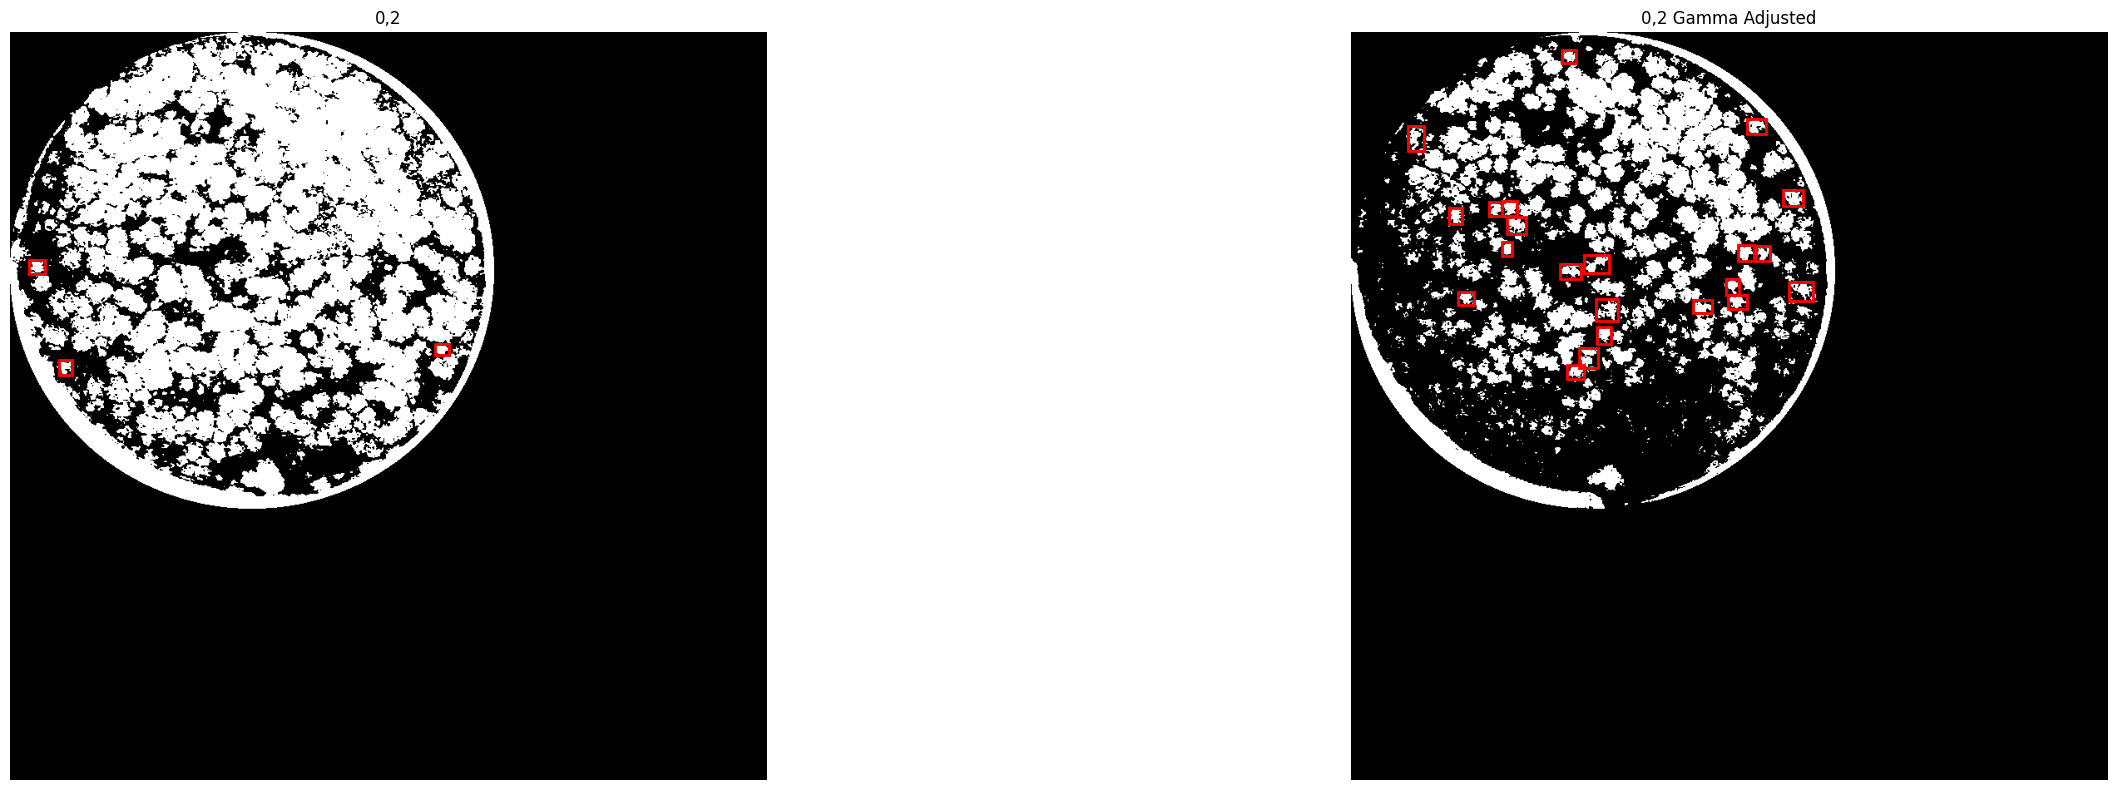

 50%|█████     | 3/6 [00:00<00:00,  3.16it/s]

IMG_6446-1,0  true count :  82
IMG_6446-1,0  :  9
IMG_6446-1,0  gamma adjusted :  43


100%|██████████| 43/43 [00:00<00:00, 4412.57it/s]


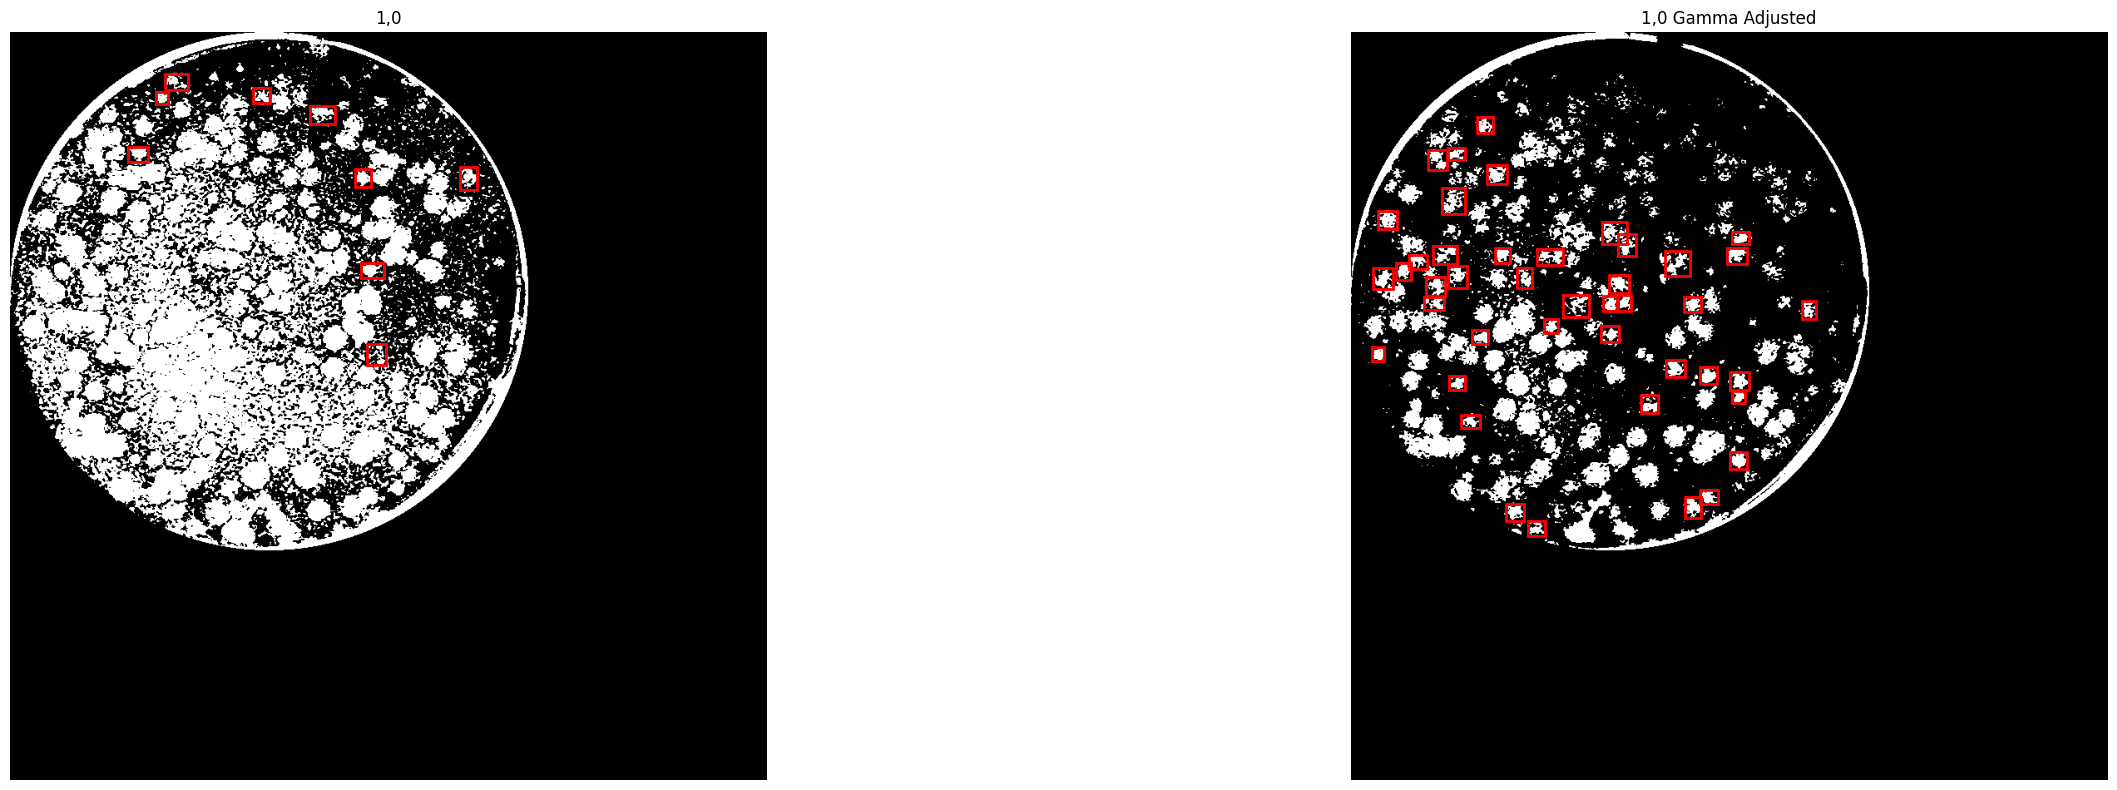

 67%|██████▋   | 4/6 [00:01<00:00,  3.18it/s]

IMG_6446-1,1  true count :  6
IMG_6446-1,1  :  10
IMG_6446-1,1  gamma adjusted :  6


100%|██████████| 6/6 [00:00<00:00, 3896.24it/s]


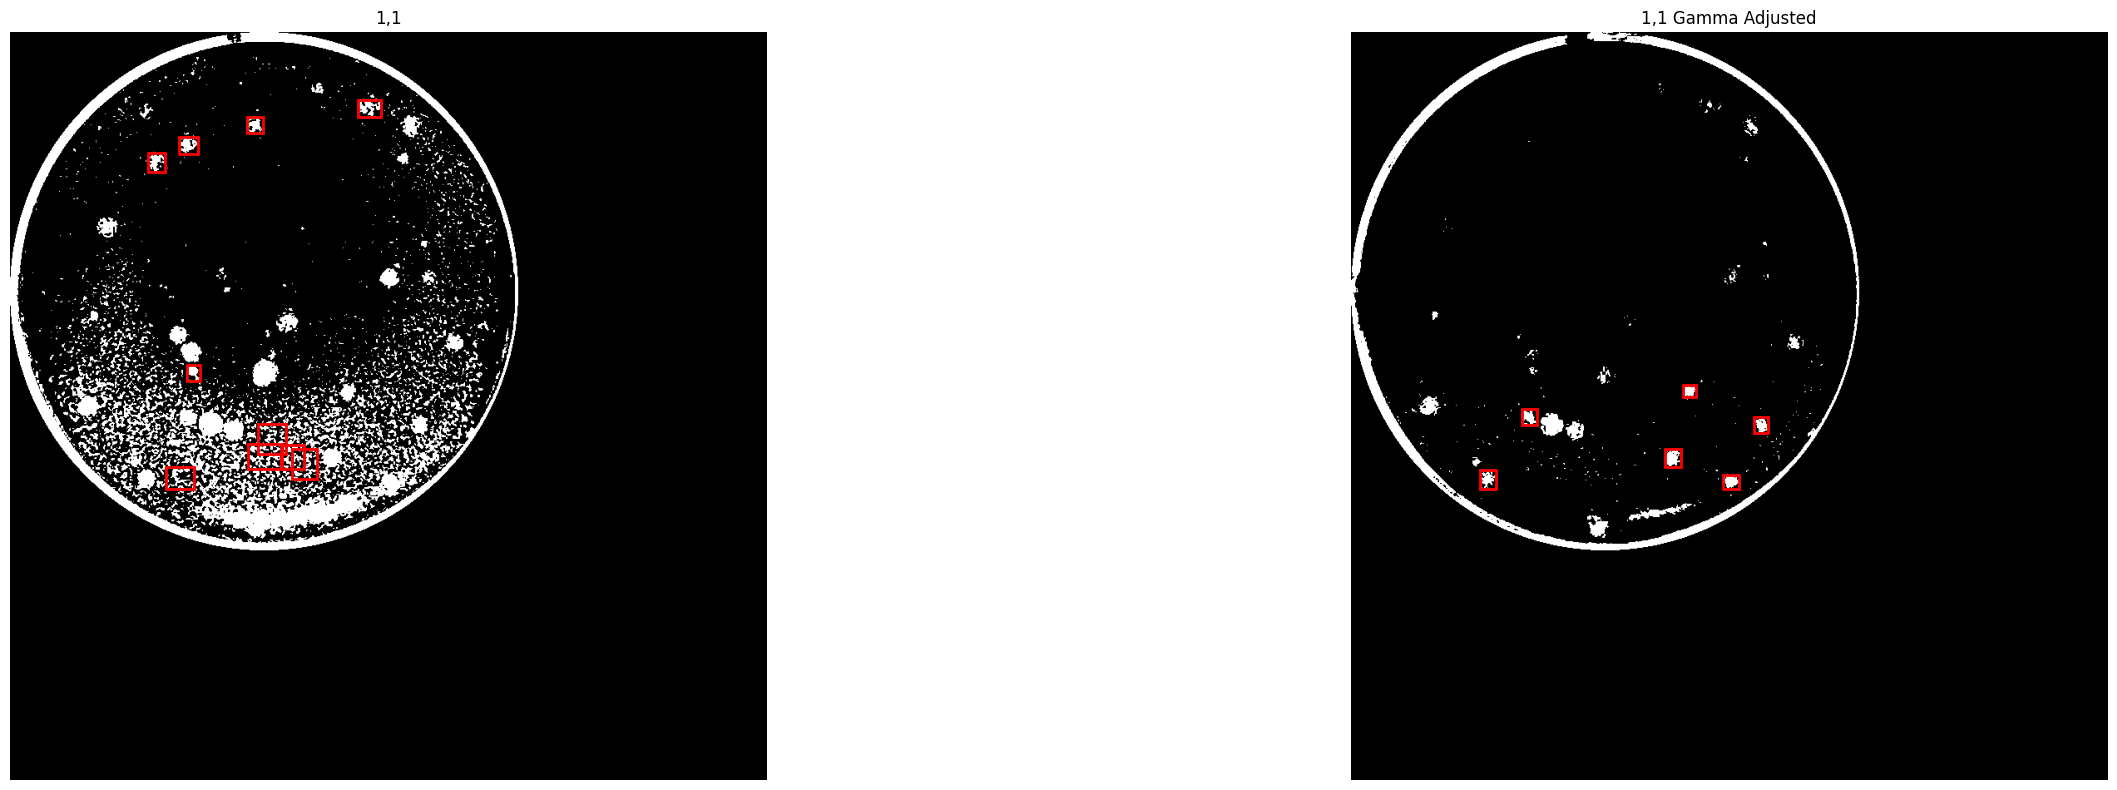

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

IMG_6446-1,2  true count :  0
IMG_6446-1,2  :  1
IMG_6446-1,2  gamma adjusted :  0


100%|██████████| 1/1 [00:00<00:00, 2597.09it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


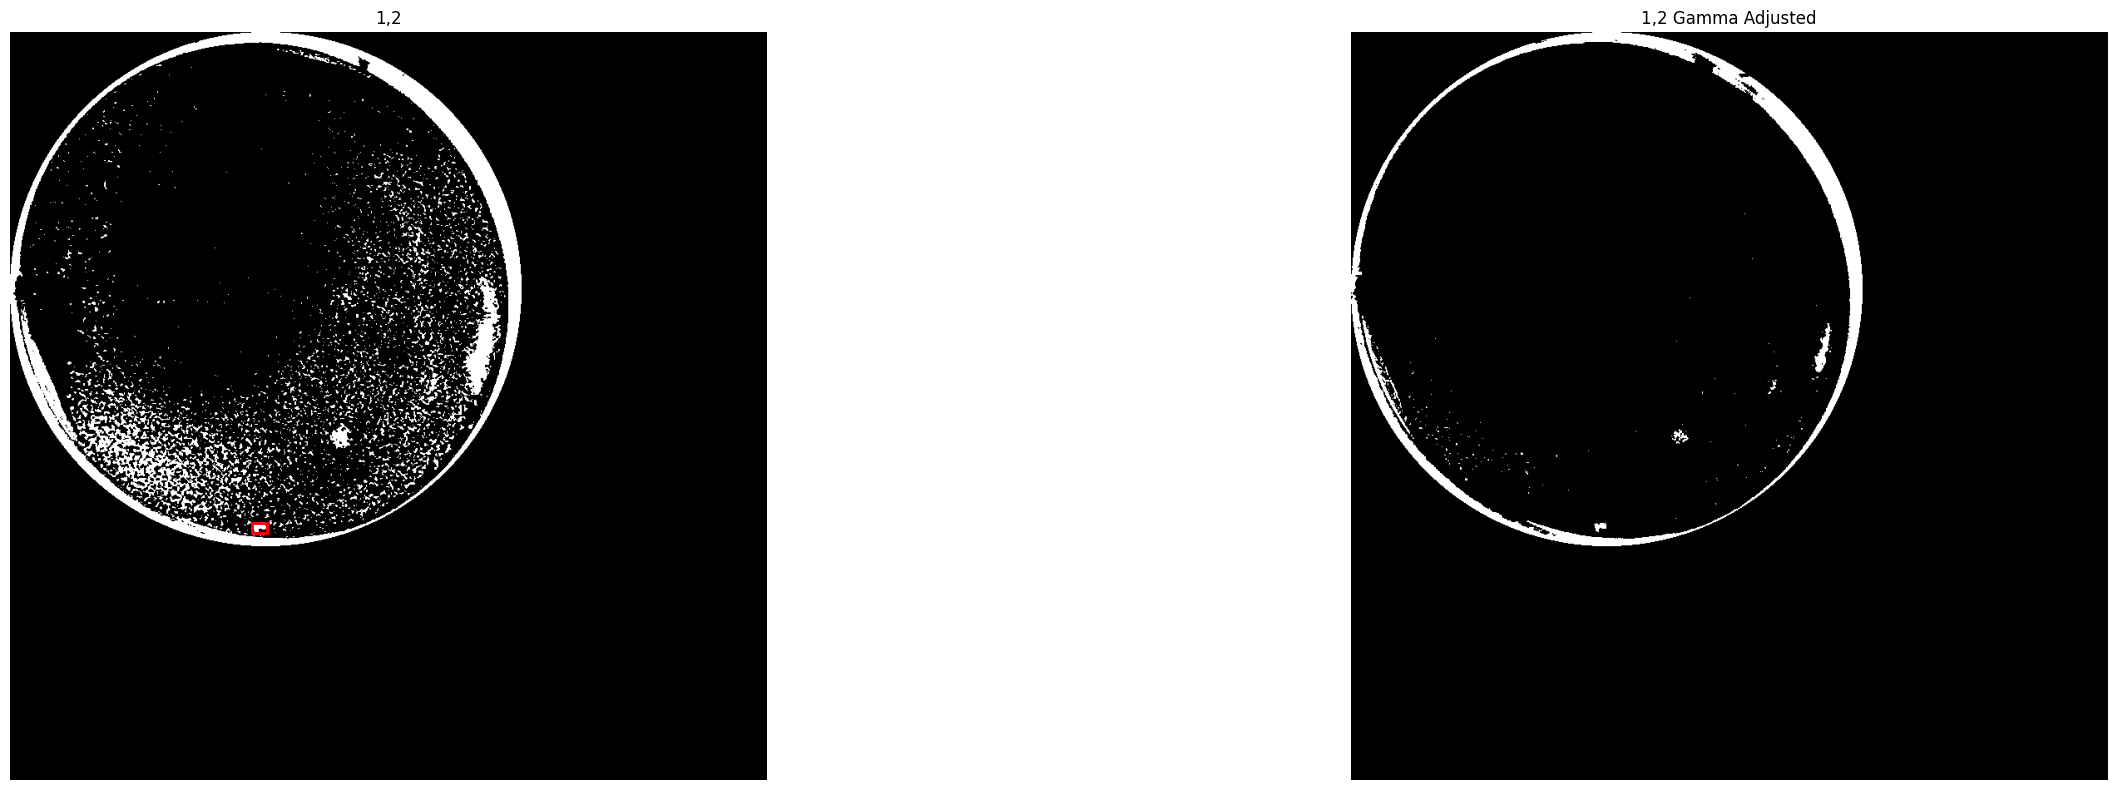

100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


[None, None, None, None, None, None]

In [18]:
#Plotting the outcome on detection based on the masks
[compare_plaque_detection_from_image(i//exp.params['crystal_violet']['ncols'],
                                    i%exp.params['crystal_violet']['ncols'],
                                    plaques_count_gt_list[i], # from 2 cells above
                                    plaques_mask_list[i],
                                    plaques_list[i],
                                    plaques_mask_gadjusted_list[i],
                                    plaques_gadjusted_list[i]) 
                                    for i in tqdm(range(len(plate_dict[plate_dirs[0]]['img'])))]

# save_path = "../../../manuscript/figs/plaque_6446_00_plaque_detection_from_image.png"

#### Plaque Bounding Boxes
###### Here we plot the bounding boxes around the detected plaques. The ```.get_plaques()``` function can take different values for ```min_area``` and ```max_area``` to give different results. We show the same bounding boxes around the masked images of the wells further on.

100%|██████████| 114/114 [00:00<00:00, 4673.68it/s]


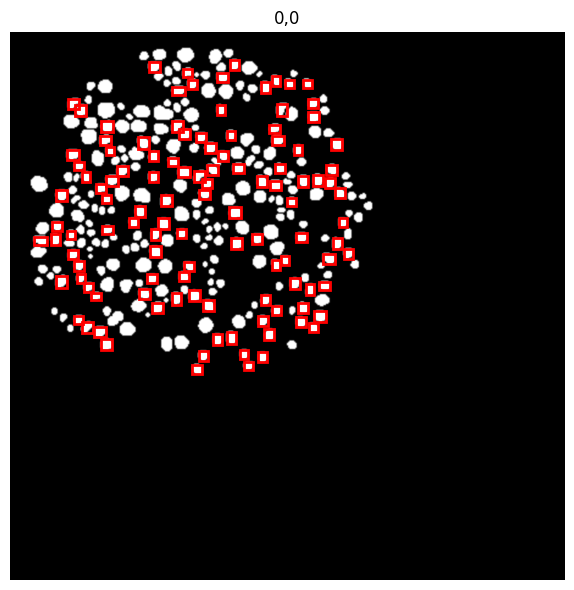

100%|██████████| 109/109 [00:00<00:00, 4343.33it/s]


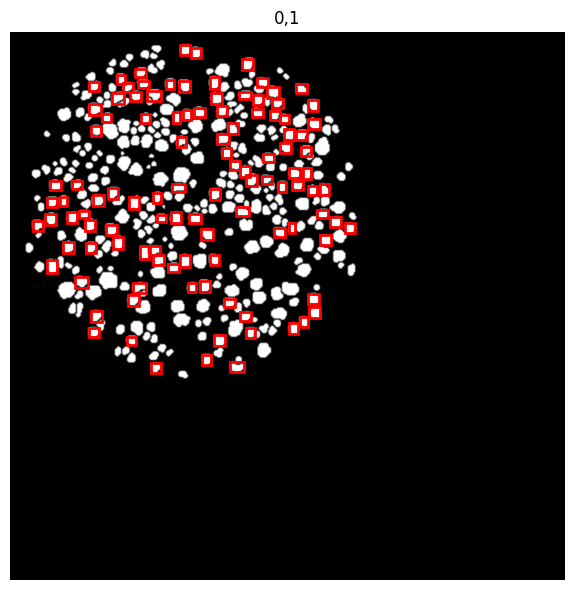

100%|██████████| 166/166 [00:00<00:00, 4868.57it/s]


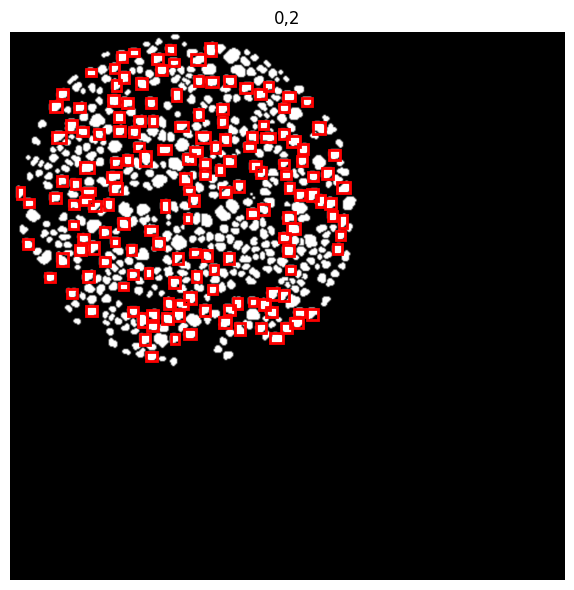

100%|██████████| 82/82 [00:00<00:00, 3697.33it/s]


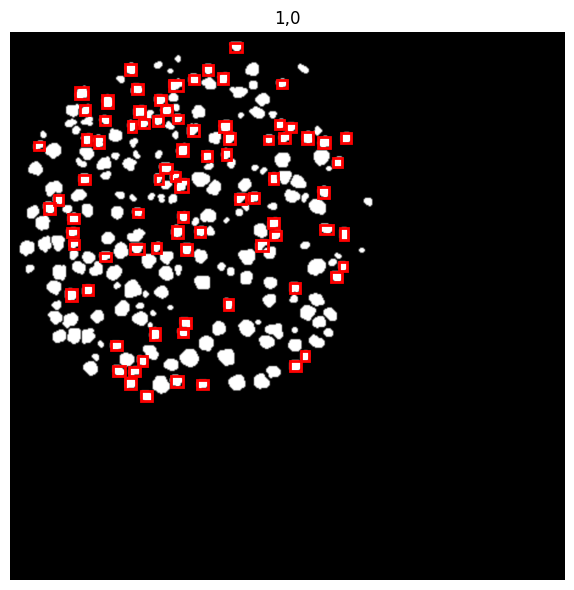

100%|██████████| 6/6 [00:00<00:00, 4117.45it/s]


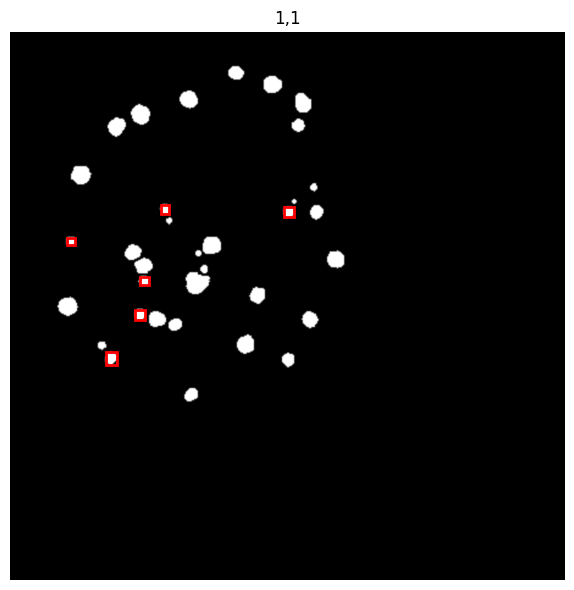

0it [00:00, ?it/s]/6 [00:06<00:01,  1.09s/it]
0it [00:00, ?it/s]


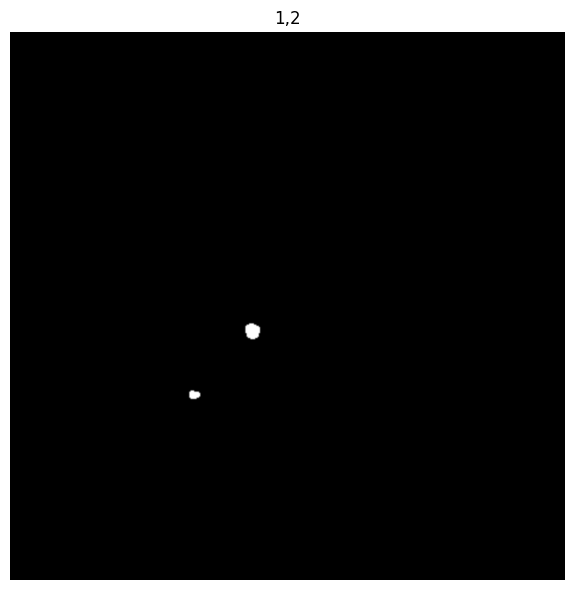

100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


[None, None, None, None, None, None]

In [19]:
# Plotting bounding boxes around individual plaques (in this case from existing binary mask, 
# but could also be done from generated mask)

[plot_bbox_plaques_mask(i//exp.params['crystal_violet']['ncols'],
                        i%exp.params['crystal_violet']['ncols'],
                        plaques_mask_gt_list[i].plaques_mask, # from 3 cells above
                        plaques_mask_gt_list[i].get_plaques()) 
                        for i in tqdm(range(len(plaques_mask_gt_list)))]

# save_path = "../../../manuscript/figs/plaque_6446_00_plaque_marked.png"

100%|██████████| 114/114 [00:00<00:00, 4816.23it/s]


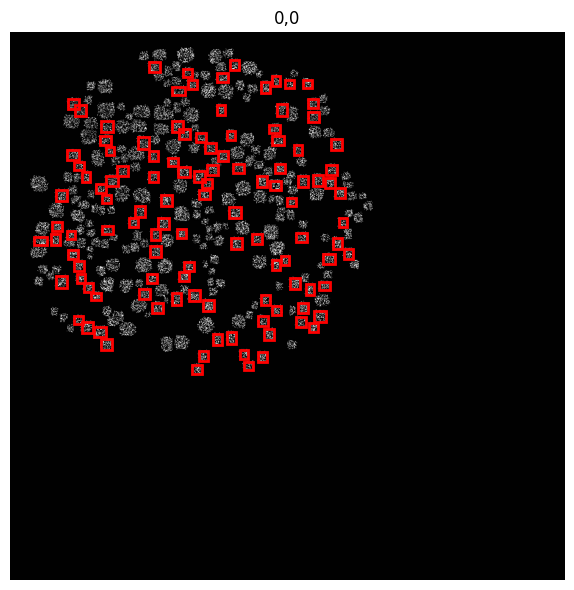

100%|██████████| 109/109 [00:00<00:00, 4818.90it/s]


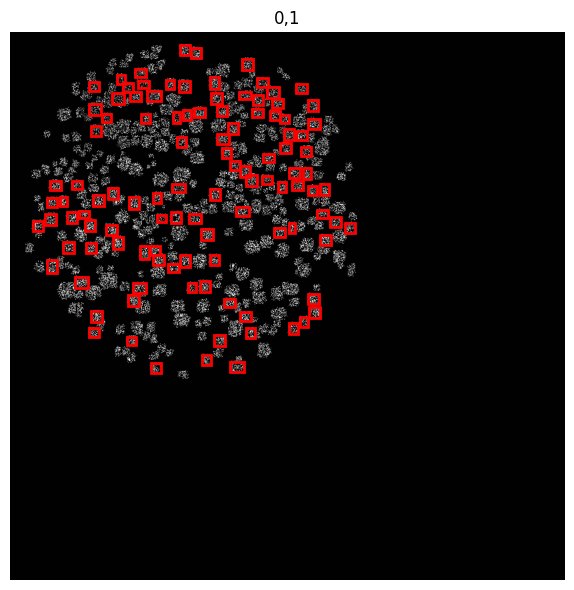

100%|██████████| 166/166 [00:00<00:00, 4883.49it/s]


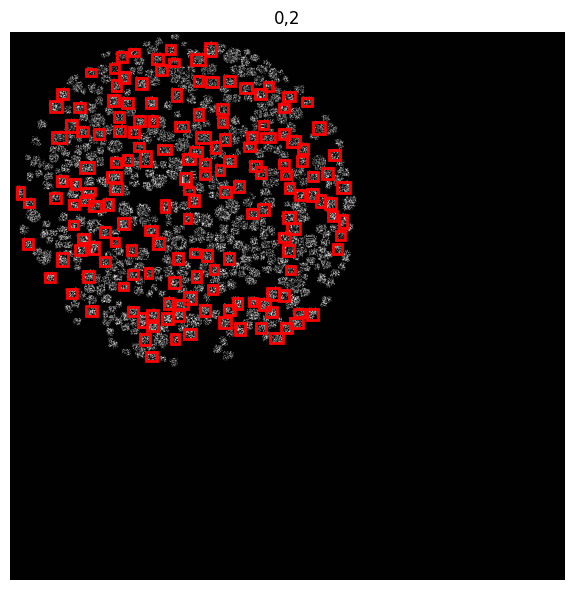

100%|██████████| 82/82 [00:00<00:00, 2426.56it/s]


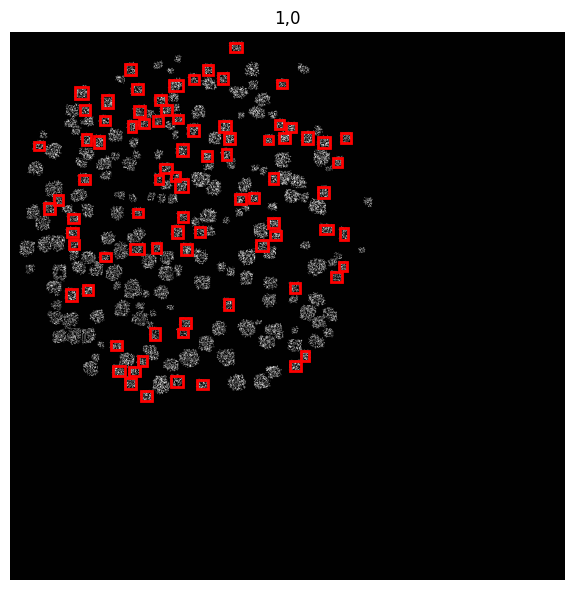

100%|██████████| 6/6 [00:00<00:00, 4018.82it/s]


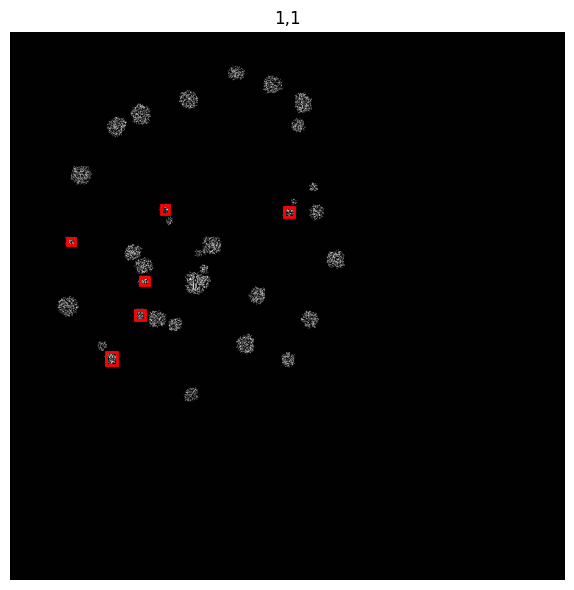

0it [00:00, ?it/s]/6 [00:06<00:01,  1.10s/it]
0it [00:00, ?it/s]


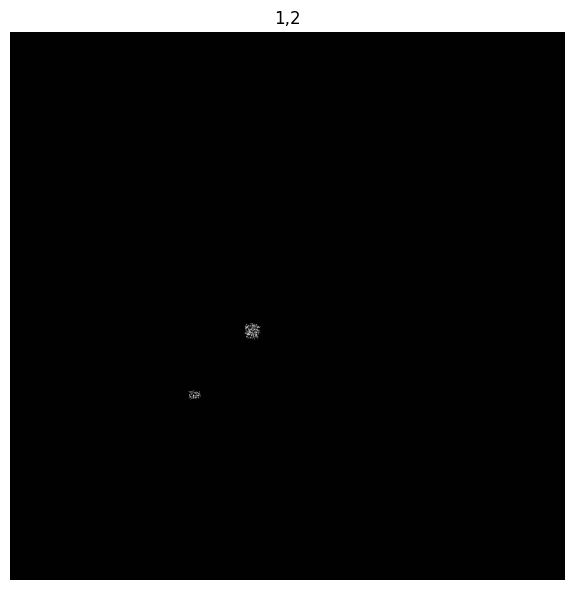

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


[None, None, None, None, None, None]

In [20]:
[plot_bbox_plaques_mask(i//exp.params['crystal_violet']['ncols'],
                        i%exp.params['crystal_violet']['ncols'],
                        plate_dict[plate_dirs[0]]['masked_img'][i], # from 3 cells above
                        plaques_mask_gt_list[i].get_plaques()) 
                        for i in tqdm(range(len(plaques_mask_list)))]
# save_path = "../../../manuscript/figs/plaque_6446_plaque_marked.png"

#### Plaque Measures
###### It may also be crucial to get other measurements about plaques in the well. For this we can use the function ```get_measure()```. It returns measurements such as ```'mean_plq_size'```, ```'med_plq_size'``` etc. We can also use the ```.plot_centroid()``` function to plot the circles around the centroid of the detected plaques and calculated radii and a circumscribing circle around the centroid of all the plaques detected. This will not plot anything in case no plaque is detected.

 17%|█▋        | 1/6 [00:01<00:05,  1.16s/it]

0 , 0  :  {'mean_plq_size': 201.16940789473685, 'med_plq_size': 194.375, 'centroid': [316.4736842105263, 298.2105263157895], 'mean_plq_ecc': 0.3285311217593585, 'mean_roundness': 4.790632072283932}


 33%|███▎      | 2/6 [00:02<00:05,  1.29s/it]

0 , 1  :  {'mean_plq_size': 206.0223623853211, 'med_plq_size': 196.5, 'centroid': [307.61467889908255, 259.27522935779814], 'mean_plq_ecc': 0.38772505325172885, 'mean_roundness': 4.370254984079839}


 50%|█████     | 3/6 [00:04<00:04,  1.60s/it]

0 , 2  :  {'mean_plq_size': 211.62198795180723, 'med_plq_size': 210.6875, 'centroid': [294.8855421686747, 269.8975903614458], 'mean_plq_ecc': 0.47424777666826984, 'mean_roundness': 4.10666997057273}


 67%|██████▋   | 4/6 [00:05<00:02,  1.38s/it]

1 , 0  :  {'mean_plq_size': 214.9001524390244, 'med_plq_size': 212.1875, 'centroid': [294.9146341463415, 276.5], 'mean_plq_ecc': 0.47755660796863303, 'mean_roundness': 5.061757127507895}


 83%|████████▎ | 5/6 [00:05<00:00,  1.04it/s]/Users/de29/Applications/miniforge3/envs/pyplaque/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/de29/Applications/miniforge3/envs/pyplaque/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


1 , 1  :  {'mean_plq_size': 187.09375, 'med_plq_size': 183.75, 'centroid': [235.0, 389.0], 'mean_plq_ecc': 0.10038982149158426, 'mean_roundness': 2.6977677321617253}
1 , 2  :  {'mean_plq_size': 0, 'med_plq_size': 0, 'centroid': [None, None], 'mean_plq_ecc': nan, 'mean_roundness': nan}


  0%|          | 0/6 [00:00<?, ?it/s]

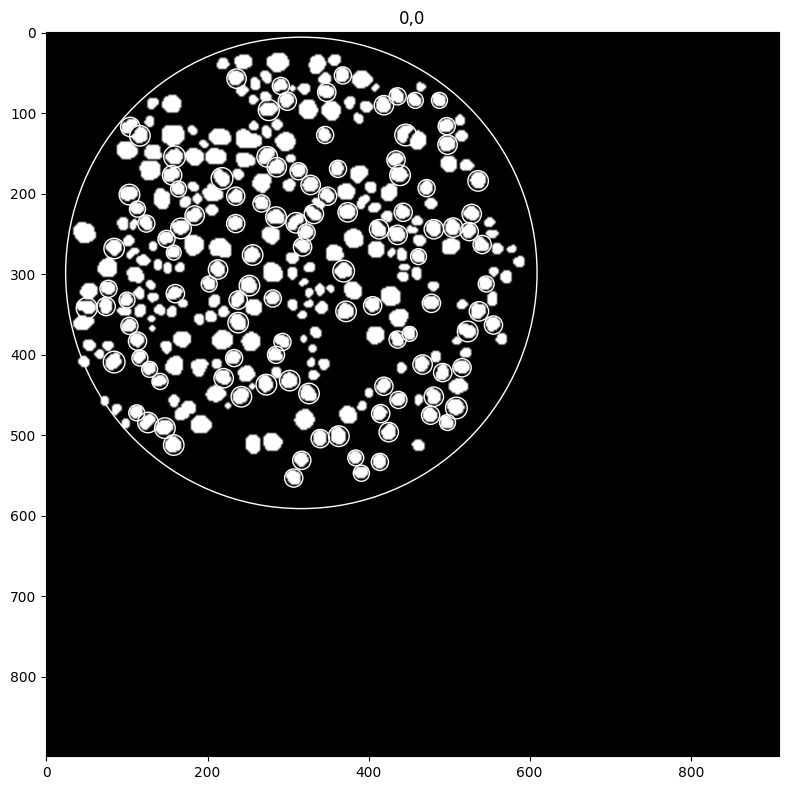

 17%|█▋        | 1/6 [00:00<00:01,  3.74it/s]

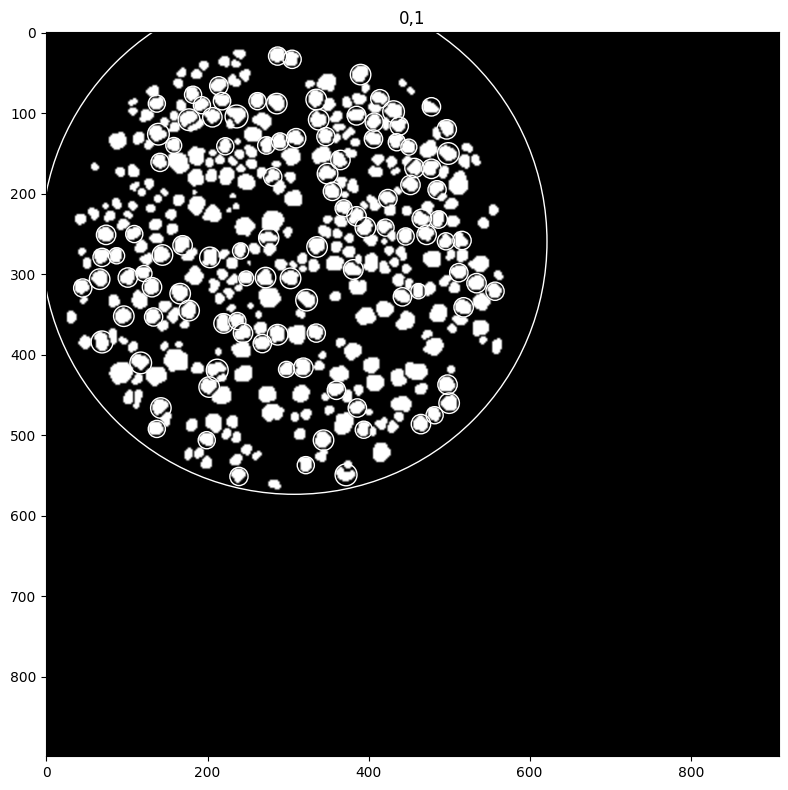

 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

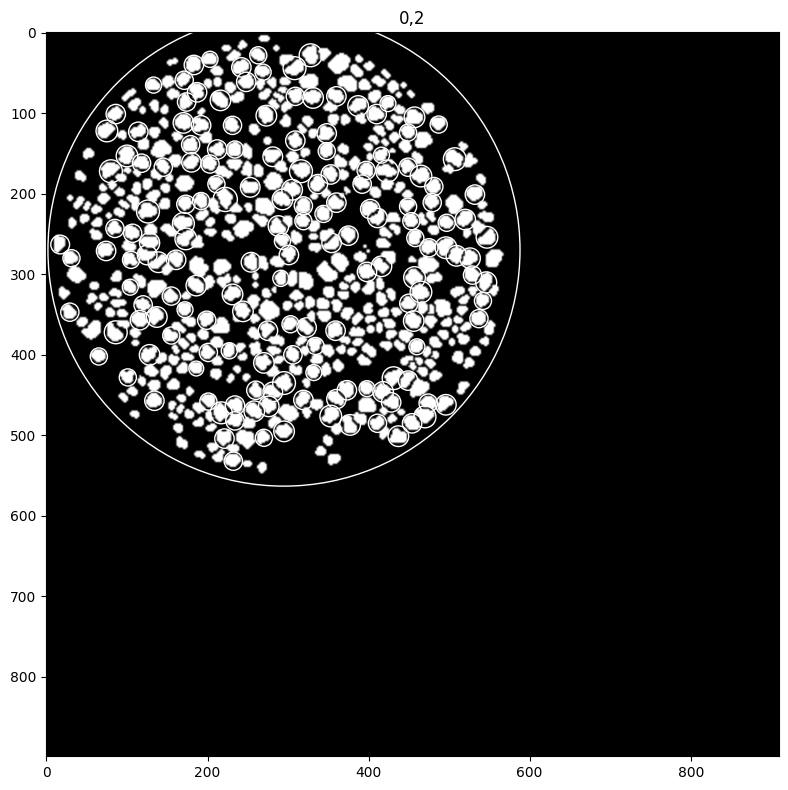

 50%|█████     | 3/6 [00:00<00:00,  3.46it/s]

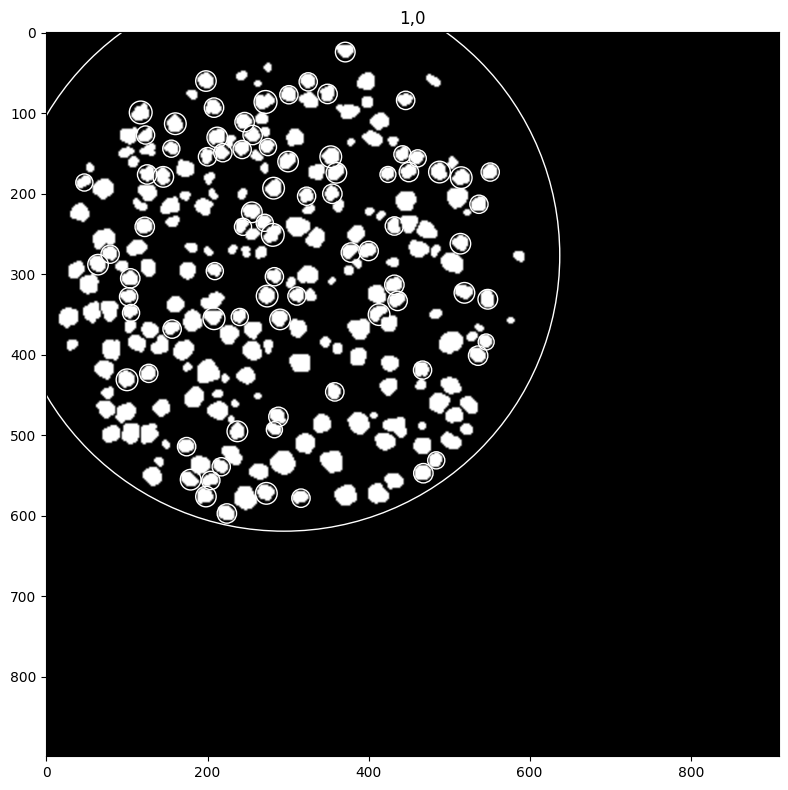

 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

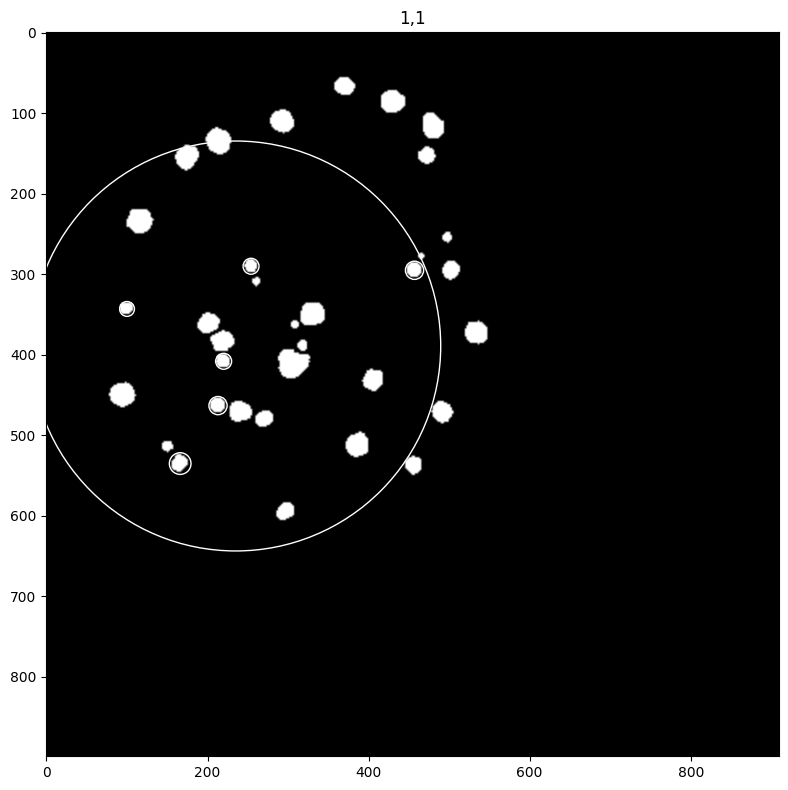

 83%|████████▎ | 5/6 [00:01<00:00,  4.59it/s]

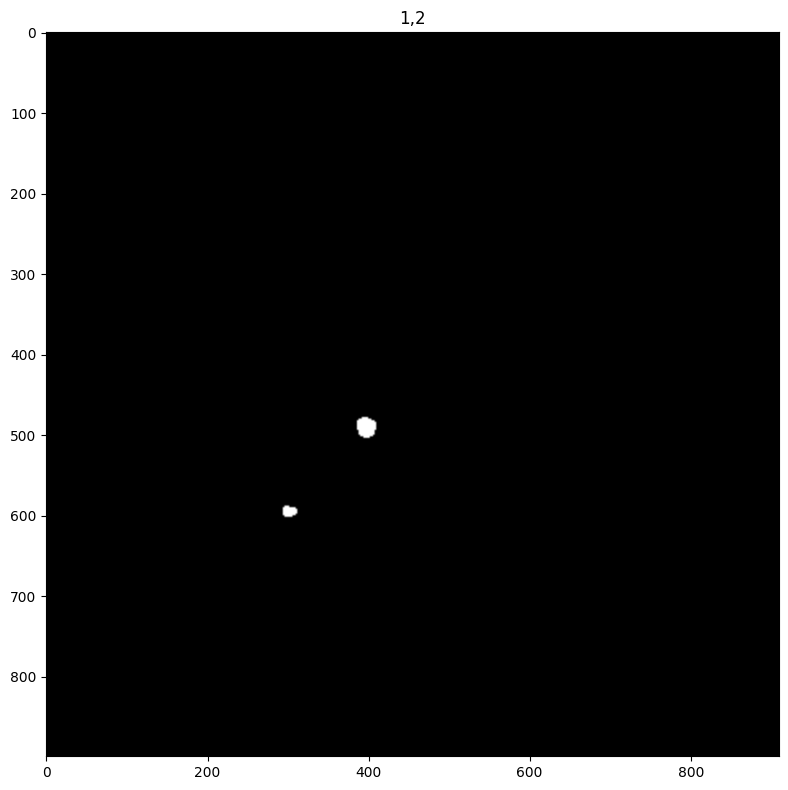

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


In [21]:
# Using the package to get some measurements about the plaques
_ = [print(i//exp.params['crystal_violet']['ncols'], ",",
            i%exp.params['crystal_violet']['ncols'], " : ",
            plaques_mask_gt_list[i].get_measure(plaques_mask_gt_list[i].get_plaques())) 
            for i in tqdm(range(len(plaques_mask_gt_list)))]

_ = [plaques_mask_gt_list[i].plot_centroid(i//exp.params['crystal_violet']['ncols'],
                            i%exp.params['crystal_violet']['ncols']) 
                            for i in tqdm(range(len(plaques_mask_gt_list)))]

#### Zooming into one Plaque
###### Here we take the image from index 0 of the plate dictionary ```plate_dict``` and for that image we get all the plaques, before zooming in into one particular plaque. We choose the plaque located lowest in the well using its centroid and drawing the bounding box around it. Using some offset we are able to zoom in into this one particular plaque and display it. Could be useful if some plaques need special observation.

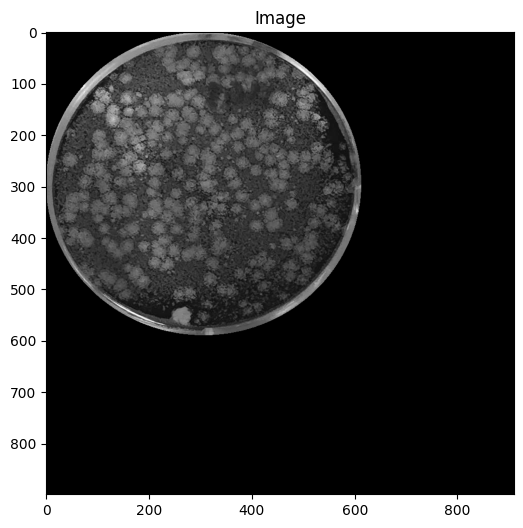

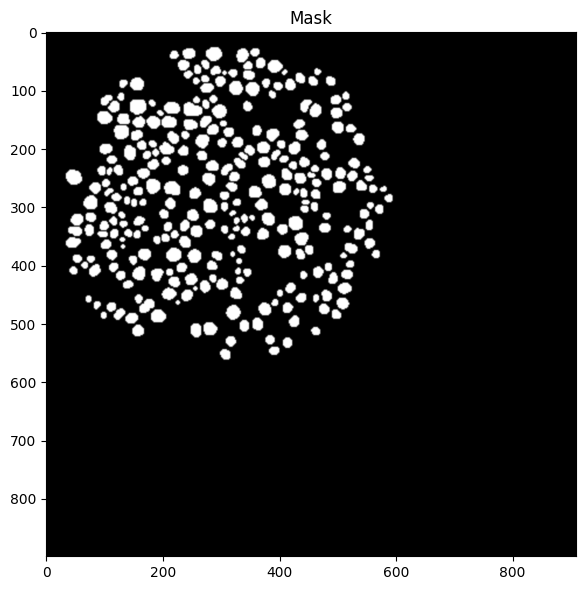

Centroid : (552.5612244897959, 307.1326530612245)
Area : 256


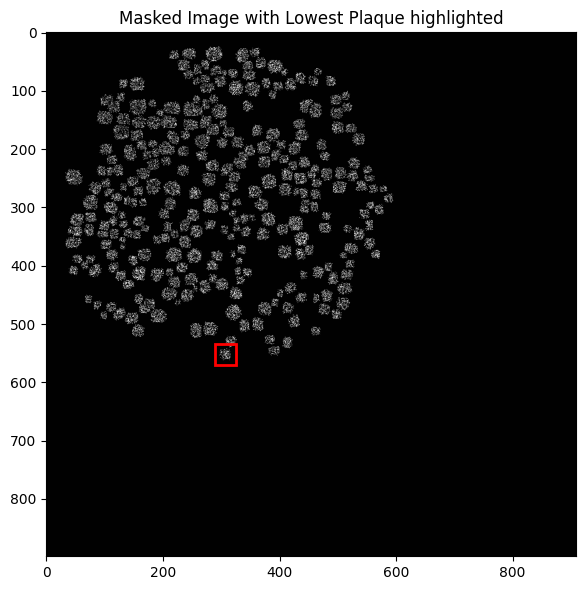

Lowest Plaque Centroid : (552.5612244897959, 307.1326530612245)
Lowest Plaque Bounding Box Area : 256


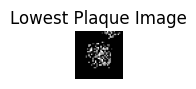

In [22]:
# Zooming in on one individual plaque and its characteristics

# Choosing different valid area range to detect plaques, otherwise default range is used
plaques_00 = plaques_mask_gt_list[0].get_plaques(min_area=15, max_area=1200)

#Plotting the image of the well
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(plate_dict[plate_dirs[0]]['img'][0], cmap='gray')
ax.set_title("Image")

#Plotting the mask of the well
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(plate_dict[plate_dirs[0]]['mask'][0], cmap='gray')
ax.set_title("Mask")

plt.tight_layout()
plt.show()

#Finding the lowest plaque in the image and printing its properties
offset = 10
min_y = 0

for plq in plaques_00:
    if (plq.bbox[2] + offset) > min_y:
        min_y = plq.bbox[2] + offset
        lowest_plaque = plq
print('Centroid :', lowest_plaque.centroid)
print('Area :', (lowest_plaque.bbox[3] - lowest_plaque.bbox[1])*
      (lowest_plaque.bbox[2] - lowest_plaque.bbox[0]))

#Finding a bounding box around the lowest plaque in the image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(plate_dict[plate_dirs[0]]['masked_img'][0], cmap='gray')
ax.set_title("Masked Image with Lowest Plaque highlighted")

rect = mpatches.Rectangle((lowest_plaque.bbox[1]-offset, lowest_plaque.bbox[0]-offset), 
                          (lowest_plaque.bbox[3]+offset) - (lowest_plaque.bbox[1]-offset), 
                          (lowest_plaque.bbox[2]+offset) - (lowest_plaque.bbox[0]-offset),
                            fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

# plt.savefig("../../../manuscript/figs/plaque_6446_lowest_plaque_marked.png",
# bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

# Showing only the plaque we have chosen, the lowest one in the image
lowest_plaque_image = plate_dict[plate_dirs[0]]['masked_img'][0] \
                                [plq.bbox[0]-offset : plq.bbox[2]+offset, 
                                plq.bbox[1]-offset : plq.bbox[3]+offset]

fig, ax = plt.subplots(figsize=(2, 1))
ax.imshow(lowest_plaque_image,cmap='gray')
ax.set_title("Lowest Plaque Image")

print('Lowest Plaque Centroid :', plq.centroid)
print('Lowest Plaque Bounding Box Area :', (plq.bbox[3] - plq.bbox[1])*(plq.bbox[2] - plq.bbox[0]))

# plt.savefig("../../../manuscript/figs/plaque_6446_00_lowest.png", bbox_inches='tight', dpi=300)

ax.set_axis_off()
plt.tight_layout()
plt.show()

#### Plaque Measures Visualisation
###### It may also be crucial to visualise measurements about plaques in the well. For this we can get the measurements into a dataframe and then use boxplots to visualise it. The values of the boxplot upper and lower bounds, q1, q2 and q3 can all be obtained separately too if viewing it in the plot is not convenient.

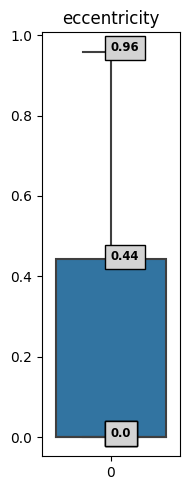

   whishi  whislo   q1  med    q3
0    0.96     0.0  0.0  0.0  0.44


In [23]:
# Other plots we can get about the plaques in a wells

ecc_ls = [plq.eccentricity() for plq in plaques_00]
roundness_ls = [plq.roundness() for plq in plaques_00]
plq_measures_df = pd.DataFrame()
plq_measures_df['eccentricity'] = ecc_ls
plq_measures_df['roundness'] = roundness_ls

stats = boxplot_quants(plq_measures_df,col_name='eccentricity',return_stats=True)
print(stats)

#### Full Crystal Violet Plate 
###### The following gives us the steps we can perform if we only have a full plate image and mask instead of individual wells. We read the plate image and mask as single images and then we the plate name, image and mask. We also show a masked version of the full plate.

In [24]:
exp_full_plate = ExperimentCrystalVioletPlaque(base_dir+'Full_plate_images/',
                                                    base_dir+'Full_plate_masks/', params = None)

# In this case, the only one image and mask corresponding to a full plate is available
# Make sure to have similar directories for images and masks(even if empty)

#Reading the full plate images and masks from the path, choosing via the pattern above to ignore 
#                                                           all other plates other than this one
full_plate_dict = exp_full_plate.load_plate_images_and_masks(additional_subfolders=None,
                                                                    file_pattern=r'6446$')

print(exp.get_number_of_plates())

2it [00:00, 9010.32it/s]
2it [00:00, 4422.04it/s]
100%|██████████| 1/1 [00:00<00:00, 30.38it/s]
1it [00:00, 112.87it/s]

1


In [25]:
# Make sure to run this after load for full plates since they get populated during load
plate_names, plate_mask_names = exp_full_plate.get_individual_plates(whole_plate=True)
print(plate_names, plate_mask_names)

['IMG_6446'] ['IMG_6446']


In [26]:
full_plate_dict[plate_names[0]]['image_name']

PosixPath('../../../data_backup/samples_crystal_violet_plaques/Full_plate_images/IMG_6446.png')

../../../data_backup/samples_crystal_violet_plaques/Full_plate_images/IMG_6446.png


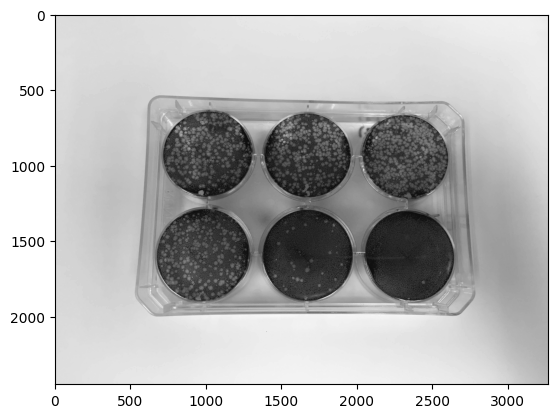

In [27]:
print(full_plate_dict[plate_names[0]]['image_name'])
plt.imshow(full_plate_dict[plate_names[0]]['img'], cmap='gray')


../../../data_backup/samples_crystal_violet_plaques/Full_plate_images/IMG_6446.png


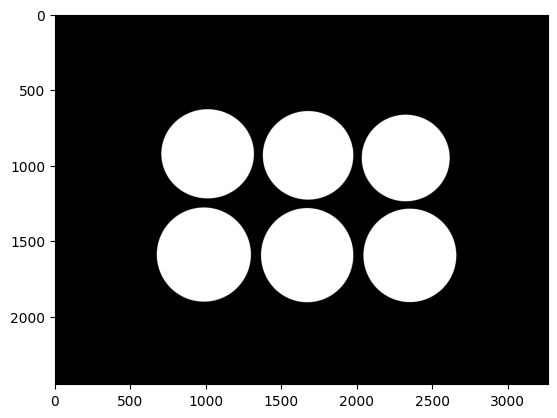

In [28]:
print(full_plate_dict[plate_names[0]]['image_name'])
plt.imshow(full_plate_dict[plate_names[0]]['mask'], cmap='gray')

100%|██████████| 1/1 [00:00<00:00, 27.60it/s]
1it [00:00, 22671.91it/s]


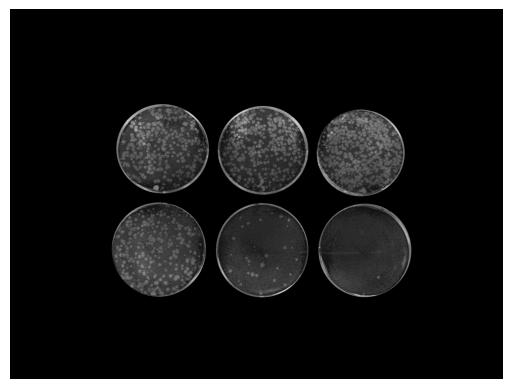

In [29]:
full_plate_dict = exp_full_plate.extract_masked_plates()
plt.figure()
plt.axis('off')
plt.imshow(full_plate_dict[plate_names[0]]['masked_img'], cmap='gray')
# plt.savefig("../../../manuscript/figs/masked_plate_6446.png", bbox_inches='tight', dpi=300)

#### Well Postition Detection and Cropping
###### We can use the class ```PlateImage()``` to hold the full plate image and mask and then use ```.get_well_positions()``` to get the well positions marked as positions of a matrix and ```.plot_well_positions()``` to plot them. While instantiating the class we can use the flag ```inverted``` to indicate whether the plate has been imaged upside down or not. This would help in the correct ordering of the columns which get reversed based on this flag. This is also useful because it can help us to crop into individual well images and masks as shown further. We have also shown an easier way to achieve the same if we are willing to not get exact well positions but only crops of the distinct wells.

In [30]:
plate_image_6446 = PlateImage(exp_full_plate.params['crystal_violet']['nrows'],
                            exp_full_plate.params['crystal_violet']['nrows'], 
                            full_plate_dict[plate_names[0]]['img'], 
                            full_plate_dict[plate_names[0]]['mask'], inverted=True)

In [31]:
# Getting automated position of the wells and checking for correctness by plotting
wells_dict_6446 = plate_image_6446.get_well_positions()
print(wells_dict_6446.keys())


dict_keys([0, 1, 2, 3, 4, 5])


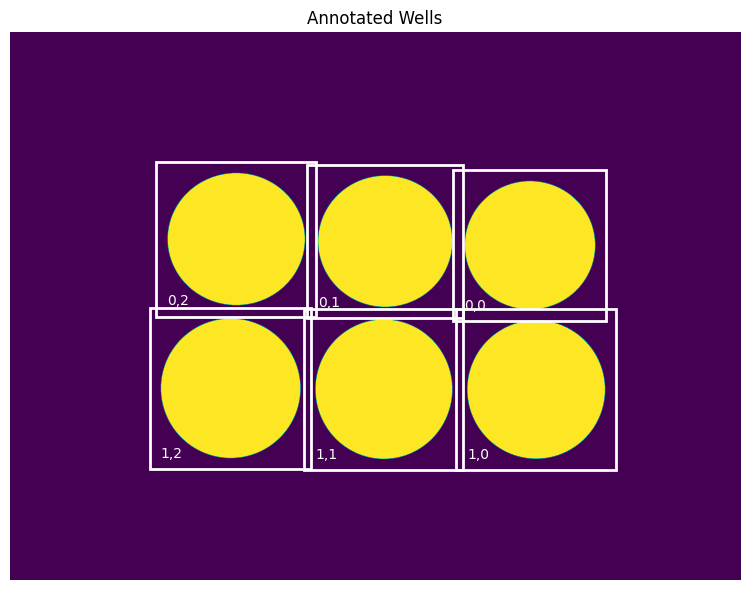

In [32]:
plate_image_6446.plot_well_positions()

#save_path = "../../../manuscript/figs/plate_6446_well_positions.svg"

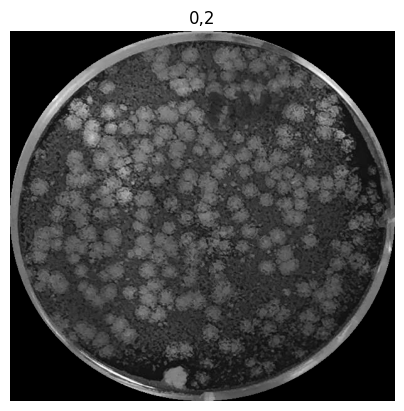

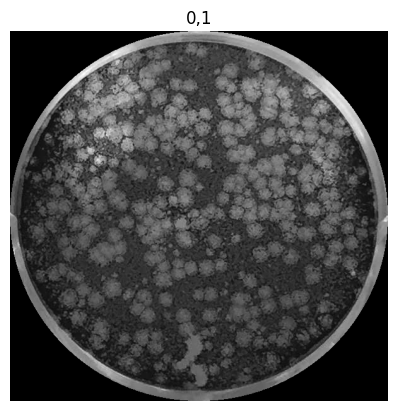

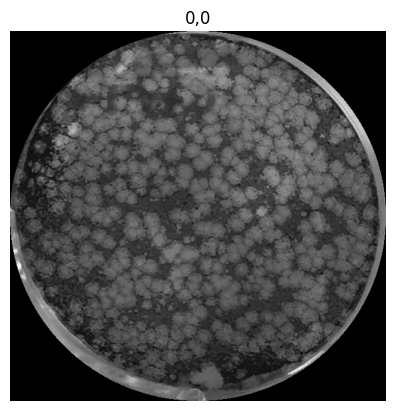

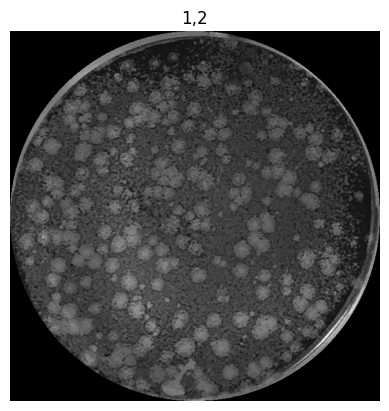

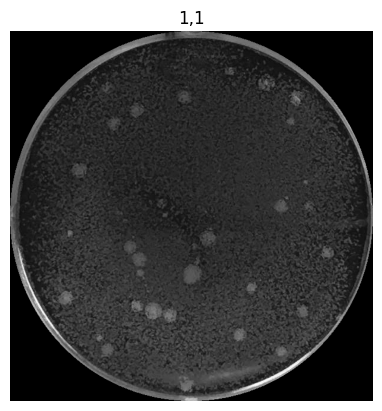

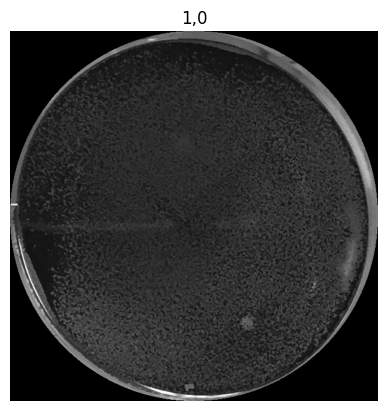

In [33]:
#Printing individual masked wells marked by positions of the wells
for idx in wells_dict_6446:
    plt.figure()
    plt.axis('off')
    plt.imshow(wells_dict_6446[idx]['masked_img'], cmap='gray')
    # plt.savefig("../../../manuscript/figs/masked_well_6446_"+str(wells_dict_6446[idx]['nrow'])
    # +str(wells_dict_6446[idx]['ncol'])+".png",bbox_inches='tight', dpi=300)
    plt.title(str(wells_dict_6446[idx]['nrow'])+","+str(wells_dict_6446[idx]['ncol']))

6


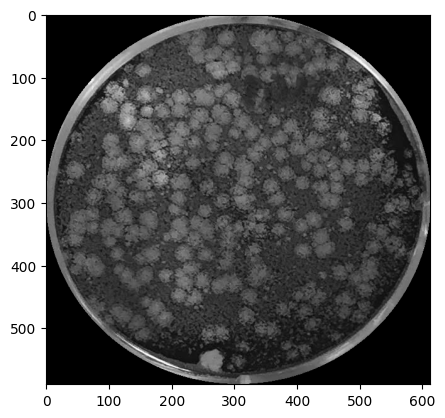

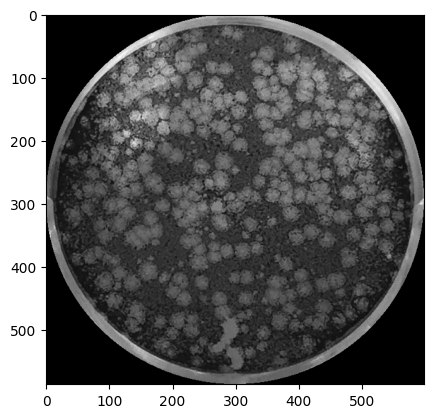

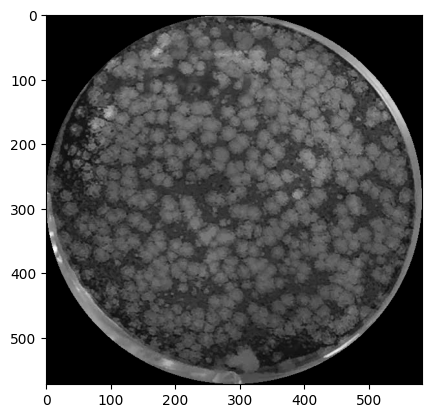

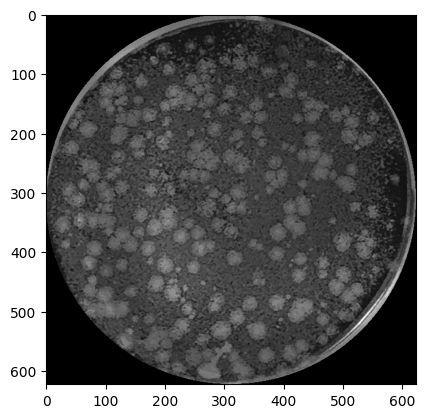

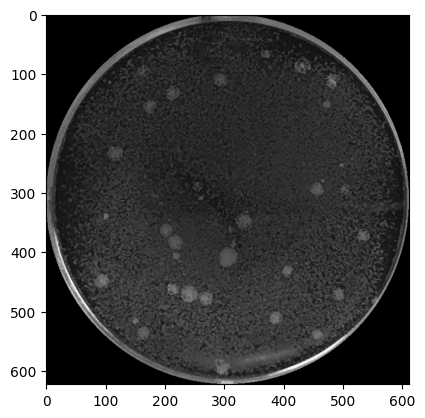

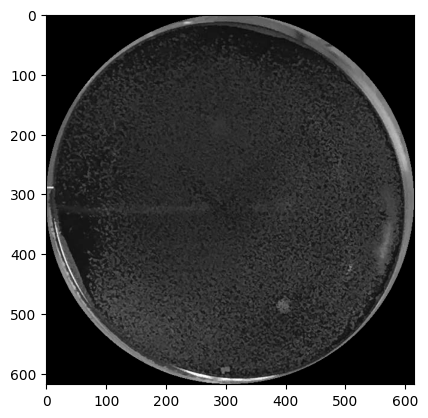

In [34]:
#In case we do not care about the position of specific wells
well_crops = plate_image_6446.get_wells()
print(len(well_crops))

for w in well_crops:
    plt.figure()
    plt.imshow(w, cmap='gray')